<a href="https://colab.research.google.com/github/Karantiwari307/Facial-emotion-detect/blob/main/Face_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive/') # access the google drive files

Mounted at /content/drive/


In [2]:
#importing libraries
#dataprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow
from tensorflow.keras.utils import to_categorical
import os
#model building
import tensorflow as tf
from keras.models import Sequential
from keras.layers import  Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
#metric
from sklearn.metrics import classification_report
#real time
import cv2
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [33]:
data=pd.read_csv('/content/drive/MyDrive/Almabetter projects/computer vision/fer2013.csv')

In [34]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [35]:
data.shape

(35887, 3)

In [36]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [37]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
#check for null values
data.isnull().sum()


emotion    0
pixels     0
Usage      0
dtype: int64

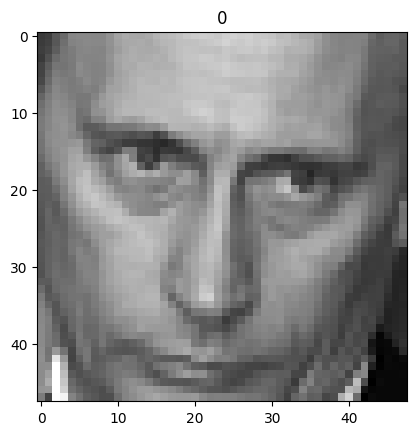

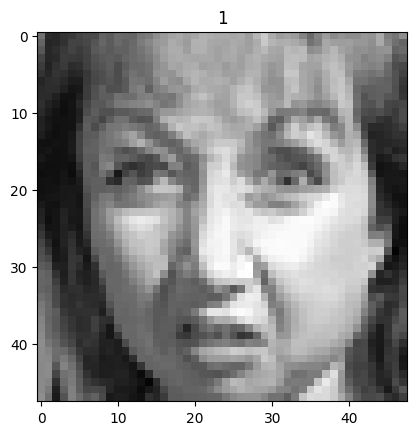

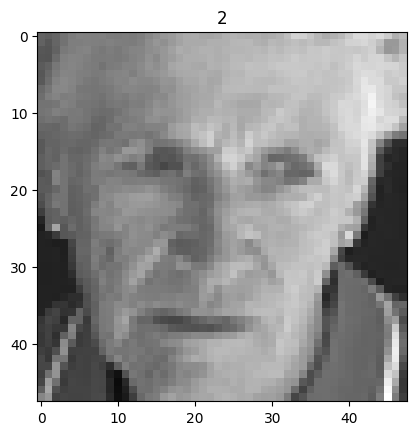

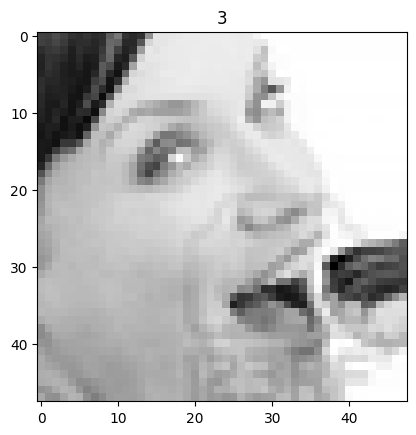

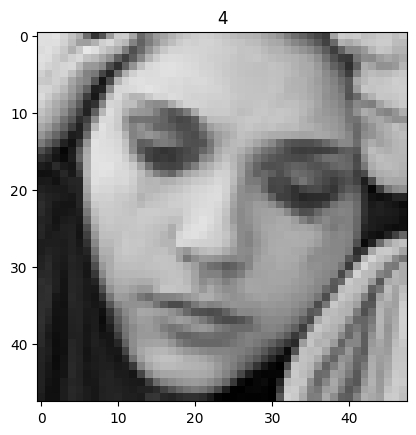

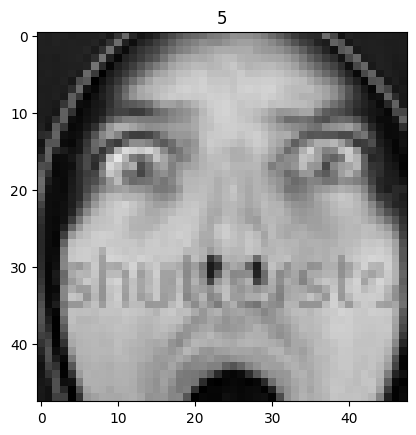

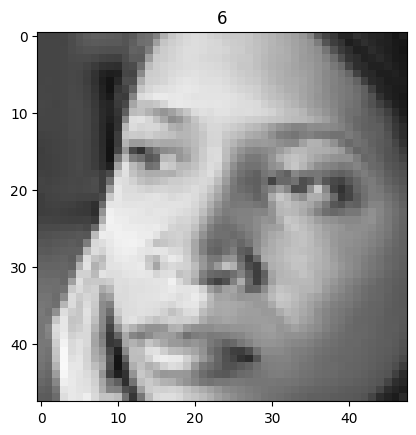

In [38]:
def show_img(df_row,pixel_string_col,class_col):
  '''The function takes in pixels in the form of strings and
    respective class of the picture; preprocessess it and returns an array of image matrix of 48X48
    and the class which can be easily plotted to visualize the image.
    Parameters:
    df_row: A row of a dataframe which has two columns, one containing pixels in string datatype
    and other labelled class
    pixel_string_col: Name of the column containing the pixels (dtype:string)
    class_col: Name of the column containing class (dtype:string)'''
  #pass observation and gather pixel and emotion class
  pixels = df_row[pixel_string_col]
  label = df_row[class_col]
  #split object and convert to array
  pic = np.array(pixels.split())
  pic = pic.reshape(48,48)
  image = np.zeros((48,48,3))
  #slice image and put the picture in three channels
  image[:,:,0] = pic
  image[:,:,1] = pic
  image[:,:,2] = pic
  #return image array and emotion
  return np.array([image.astype(np.uint8), label])

#iterate over all emotions and plot the pixels through the function
import matplotlib.pyplot as plt
for emotion in range(1,8):
    picture = data[data['emotion']== emotion-1].iloc[9]
    picture = show_img(picture,'pixels','emotion')
    plt.imshow(picture[0])
    plt.title(picture[1])
    plt.show()

Text(0.5, 1.0, 'Emotion Distribution')

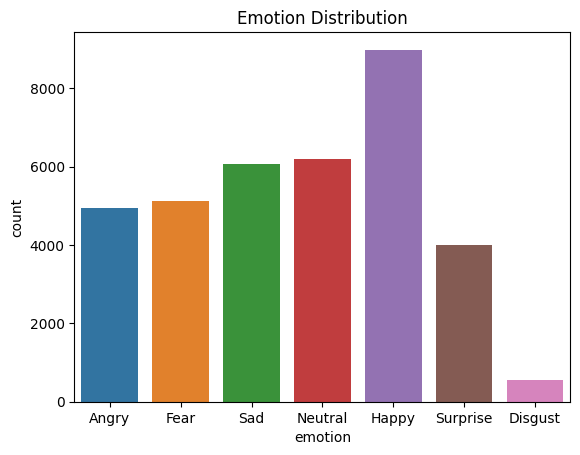

In [6]:

#plotting a bar graph of the emotions
#create dic of emotions
emo_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise',6:'Neutral'}
#creating a copy of data with actual categorial emotions
df1 = data.copy()
df1['emotion'] = df1['emotion'].map(emo_dict)
#plotting
sns.countplot(x=df1['emotion'])
plt.title('Emotion Distribution')


In [94]:

#splitting the data into train, validation and test set
train_data = data[data['Usage']=='Training']
val_data   = data[data['Usage']=='PublicTest']
test_data  = data[data['Usage']=='PrivateTest']
print("The shape of training set is: {}, \nThe shape of validation set is: {}, \nThe shape of test set is: {}".format(train_data.shape, val_data.shape, test_data.shape))


The shape of training set is: (28709, 3), 
The shape of validation set is: (3589, 3), 
The shape of test set is: (3589, 3)


In [19]:
val_data

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest
...,...,...,...
32293,4,178 176 172 173 173 174 176 173 166 166 206 22...,PublicTest
32294,3,25 34 42 44 42 47 57 59 59 58 54 51 50 56 63 6...,PublicTest
32295,4,255 255 255 255 255 255 255 255 255 255 255 25...,PublicTest
32296,4,33 25 31 36 36 42 69 103 132 163 175 183 187 1...,PublicTest


In [96]:
#resetting index and dropping usage
for elem in [train_data,val_data,test_data]:
    elem.reset_index(drop=True, inplace= True)
    elem.drop('Usage',axis=1,inplace=True)

In [97]:
val_data

,emotion,pixels
0,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,1,156 184 198 202 204 207 210 212 213 214 215 21...
2,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,6,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
...,...,...
3584,4,178 176 172 173 173 174 176 173 166 166 206 22...
3585,3,25 34 42 44 42 47 57 59 59 58 54 51 50 56 63 6...
3586,4,255 255 255 255 255 255 255 255 255 255 255 25...
3587,4,33 25 31 36 36 42 69 103 132 163 175 183 187 1...


In [21]:
train_data

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


In [68]:
test_data

,emotion,pixels
0,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...
1,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...
2,6,232 240 241 239 237 235 246 117 24 24 22 13 12...
3,4,200 197 149 139 156 89 111 58 62 95 113 117 11...
4,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...
...,...,...
3584,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
3585,3,178 174 172 173 181 188 191 194 196 199 200 20...
3586,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
3587,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [98]:
# #data preparation for test
test_data['pixels'] = test_data['pixels'].apply(lambda pixels : [int(pixel) for pixel in pixels.split()])
X_test = np.array(test_data['pixels'].tolist(), dtype='float32').reshape(-1,48,48,1)/255.0
y_test = to_categorical(test_data['emotion'],num_classes = 7,dtype ="uint8")

# converting test image from greyscale to rgb
import cv2
import numpy as np
# Convert them to RGB format
X_test_rgb = np.array([cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) for image in X_test])

In [109]:
X_test_rgb.shape

(3589, 48, 48, 3)

In [100]:
test_data

,emotion,pixels
0,0,"[170, 118, 101, 88, 88, 75, 78, 82, 66, 74, 68..."
1,5,"[7, 5, 8, 6, 7, 3, 2, 6, 5, 4, 4, 5, 7, 5, 5, ..."
2,6,"[232, 240, 241, 239, 237, 235, 246, 117, 24, 2..."
3,4,"[200, 197, 149, 139, 156, 89, 111, 58, 62, 95,..."
4,2,"[40, 28, 33, 56, 45, 33, 31, 78, 152, 194, 200..."
...,...,...
3584,6,"[50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, 3..."
3585,3,"[178, 174, 172, 173, 181, 188, 191, 194, 196, ..."
3586,0,"[17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, 2..."
3587,3,"[30, 28, 28, 29, 31, 30, 42, 68, 79, 81, 77, 6..."


In [42]:
#image data directory creation
path='/content/drive/MyDrive/Almabetter projects/computer vision'

def create_dir(path,class_list):
  ''' The function takes in the path and list of the classes to
        create directories for different  classes
        Parameters:
        path: The path where train and validation directories needs to be created.
        class_list: The list of labels in the dataset.'''
  #Create train and validation directories
  train_path = os.path.join(path,'train')
  val_path = os.path.join(path,'valid')
  os.mkdir(train_path)
  os.mkdir(val_path)
  for data_path,cat in {train_path:'train-',val_path:'valid-'}.items():
    for label in class_list:
      label_dir = os.path.join(data_path,cat+str(label))
      os.mkdir(label_dir)


In [11]:
#creating directories
create_dir(path,[0,1,2,3,4,5,6])

In [44]:
train_path = "/content/drive/MyDrive/Almabetter projects/computer vision/train"
val_path =  "/content/drive/MyDrive/Almabetter projects/computer vision/valid"

In [45]:

#saving images
def save_imgs(df,df_path,pixel_col,class_col,class_list,prefix):
  '''This function takes in the dataframes and
     creates images and saves images in directories.
     Parameters:
     df: Dataframe that needs to be converted.
     df_path: Path to the directory (dtype-string)
              Example- If the training dataframe is fed, df_path should be the path
              to the train directory created.
     pixel_col: Name of the column containing pixels in string object
     class_col: Name of the column for data labels
     prefix: train- for training set, valid- for validation set  '''

  for i in range(len(df)):
      pixel_string = df[pixel_col][i]
      pixels = list(map(int, pixel_string.split()))

      matrix = np.array(pixels).reshape(48,48).astype(np.uint8)
      img = Image.fromarray(matrix)
      for label in class_list:
        if str(df[class_col][i]) in prefix + str(label):
            img.save(df_path +'/'+ prefix + str(label)+'/'+ prefix + str(label)+'-'+str(i)+'.png')
        else:
          continue


In [ ]:
#train images
save_imgs(train_data,train_path,'pixels','emotion',[0,1,2,3,4,5,6],'train-')
#validation images
save_imgs(val_data,val_path,'pixels','emotion',[0,1,2,3,4,5,6],'valid-')

In [47]:
#Image preprocessing
from keras.preprocessing.image import ImageDataGenerator
def img_data_gen(train_path,val_path,target_size,batch_size,color_mode,class_mode):
  ''' The function generates augmented data rescales the validation images given the paths.
  Parameters:
  train_path: path to the train directory of the images
  val_path: path to the validation directory of images
  target_size: image target size; example: (48*48)
  batch_size: The batches in which the data is supposed to be fed
  color_mode: example: 'grayscale' or 'rgb'
  class_mode: example: 'binary' or 'categorical'
   '''
  #Initialising the generators for the train and validation set
  #The rescale parameter ensures the input range in [0, 1]
  train_datagen = ImageDataGenerator(rescale = 1./255,rotation_range = 10,horizontal_flip = True,width_shift_range=0.1,height_shift_range=0.1,
                                    fill_mode = 'nearest')
  val_datagen = ImageDataGenerator(rescale = 1./255) #validation data should not be augmented

  train_generator = train_datagen.flow_from_directory(
          train_path,
          target_size=target_size,
          batch_size=batch_size,
          color_mode=color_mode,
          seed = 42,
          shuffle= True,
          class_mode=class_mode)

  val_generator = val_datagen.flow_from_directory(
          val_path,
          target_size=target_size,
          batch_size=batch_size,
          color_mode=color_mode,
          seed = 42,
          shuffle = True,
          class_mode=class_mode)

  return train_generator, val_generator

In [48]:
#image generators
train_gen, val_gen = img_data_gen(train_path,val_path,target_size=(48,48),batch_size=64,color_mode='rgb',class_mode='categorical')



Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


transfer learning

In [49]:

# creating a base model using resnet and loading the pretrained weights
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(48,48,3),include_top = False, weights = 'imagenet')
base_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                          

In [50]:
# making all the layers except last 4 layers non trainable
for layer in base_model.layers[:-4]:
    layer.trainable = False

# building modek in top of base model

epoch=20
batch_size=32

model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(BatchNormalization())


# fully connected 1 st layer

model.add(Dense(450,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(250,activation = 'relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


#output layer
model.add(Dense(7, activation='softmax'))

# Final model summary
model.summary()

# compiling the model

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# #training
earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience = 15, verbose=1,restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 450)               3686850   
                                                                 
 batch_normalization_1 (Batc  (None, 450)              1800      
 hNormalization)                                        

In [51]:
# training model
history=model.fit_generator(train_gen,
                steps_per_epoch=len(train_data)//64,
                epochs=epoch,
                callbacks=earlystop,
                verbose= 1,
                validation_data=val_gen,
                validation_steps=len(val_data)//64)

Epoch 1/20
448/448 [==============================] - 470s 1s/step - loss: 2.0330 - accuracy: 0.2301 - val_loss: 1.8779 - val_accuracy: 0.2765
Epoch 2/20
448/448 [==============================] - 446s 995ms/step - loss: 1.8204 - accuracy: 0.2684 - val_loss: 1.8599 - val_accuracy: 0.2570
Epoch 3/20
448/448 [==============================] - 446s 996ms/step - loss: 1.7658 - accuracy: 0.2852 - val_loss: 1.7617 - val_accuracy: 0.3027
Epoch 4/20
448/448 [==============================] - 445s 993ms/step - loss: 1.7431 - accuracy: 0.2980 - val_loss: 1.8071 - val_accuracy: 0.2980
Epoch 5/20
448/448 [==============================] - 484s 1s/step - loss: 1.7295 - accuracy: 0.3005 - val_loss: 1.8260 - val_accuracy: 0.2905
Epoch 6/20
448/448 [==============================] - 445s 994ms/step - loss: 1.7188 - accuracy: 0.3065 - val_loss: 1.7253 - val_accuracy: 0.3086
Epoch 7/20
448/448 [==============================] - 445s 993ms/step - loss: 1.7126 - accuracy: 0.3132 - val_loss: 1.8409 - val_a

Text(0.5, 1.0, 'Loss Plots for Training and Validation Sets')

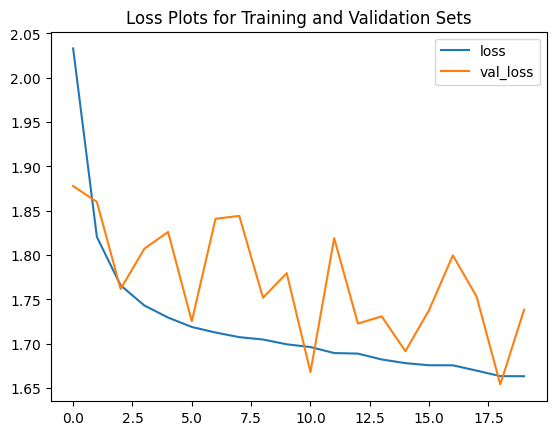

In [52]:
#saving the history of the model in dataframe
model_df = pd.DataFrame(history.history)


#Plotting Loss
model_df[['loss','val_loss']].plot()
plt.title("Loss Plots for Training and Validation Sets")

In [53]:
model_df


,loss,accuracy,val_loss,val_accuracy
0,2.033044,0.230058,1.877865,0.276507
1,1.820438,0.268354,1.859947,0.256975
2,1.765818,0.285216,1.761650,0.302734
3,1.743103,0.297993,1.807128,0.297991
4,1.729474,0.300506,1.826037,0.290458
5,1.718833,0.306546,1.725276,0.308594
6,1.712591,0.313213,1.840896,0.278181
7,1.707366,0.315308,1.844212,0.289342
8,1.704703,0.316006,1.751827,0.321987
9,1.699304,0.317577,1.779610,0.293527


Text(0.5, 1.0, 'Accuracy Plots for Training and Validation Sets')

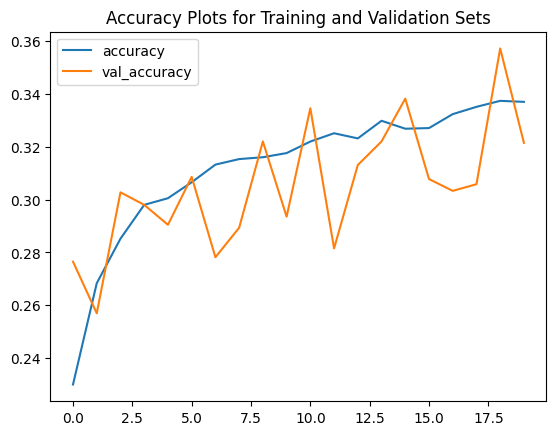

In [54]:

#Plotting accuracy
model_df[['accuracy','val_accuracy']].plot()
plt.title("Accuracy Plots for Training and Validation Sets")

In [130]:
#test predictions
true_y  = np.argmax(y_test,axis=1)
pred_y = np.argmax(model.predict(X_test_rgb),axis=1)


113/113 [==============================] - 37s 332ms/step


Normalized confusion matrix
classification_report
              precision    recall  f1-score   support

           0       0.43      0.07      0.11       491
           1       0.00      0.00      0.00        55
           2       0.21      0.06      0.09       528
           3       0.33      0.78      0.47       879
           4       0.42      0.05      0.09       594
           5       0.29      0.56      0.38       416
           6       0.38      0.25      0.30       626

    accuracy                           0.33      3589
   macro avg       0.29      0.25      0.21      3589
weighted avg       0.34      0.33      0.26      3589

Accuracy Score: 0.32711061577040956


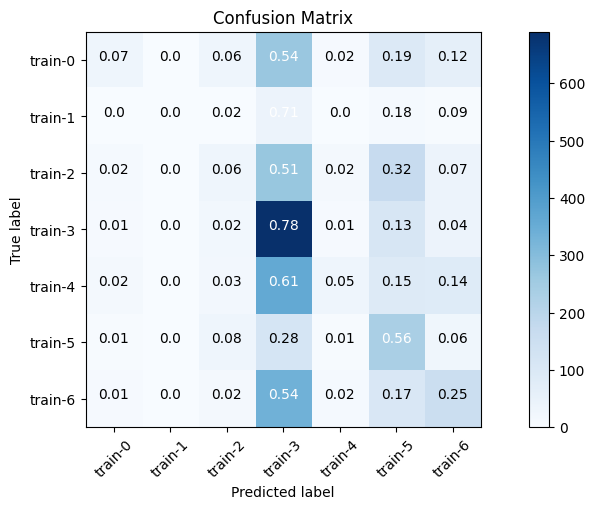

In [129]:

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#shuffle=False
target_names = []
for key in train_gen.class_indices:
    target_names.append(key)


#Confution Matrix


cm = confusion_matrix(true_y, pred_y)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# classification_report
print('classification_report')
print(classification_report(true_y,pred_y))

# Accuracy Score
accuracy = accuracy_score(true_y, pred_y)

print("Accuracy Score:", accuracy)
